In [5]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt

In [6]:
#from DA_PoC.dynamical_systems.sw_numerical_model 
from DA_PoC.dynamical_systems.examples.sw import SWModelJax
from DA_PoC.common.numerical_model import NumericalModel

from DA_PoC.common.observation_operator import LinearObservationOperator
import numpy as np

In [7]:
n_x = 32
dx = 5e3
n_y = 32
dy = 5e3
swmodel = SWModelJax(n_x, dx, n_y, dy, periodic_x=True)


In [64]:
state_dimension = 3 * swmodel.state_variable_length
obs_dimension = swmodel.state_variable_length
h_no_nan = np.eye(swmodel.state_variable_length)
for i in range(swmodel.state_variable_length):
    if i % 32 == 0:
        h_no_nan[i, i] = 0
        h_no_nan[i-1, i-1] = 0

H_obs = np.hstack(
    [
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        h_no_nan,
    ]
)
obs_operator = LinearObservationOperator(Hmatrix=H_obs)
window = 15
# print(f"{lorenz.obs.shape=}")
# print(f"{lorenz.H=}")
numerical_model_sw = NumericalModel(state_dimension, obs_dimension)
background = np.zeros(state_dimension)
background[swmodel.slice_h] = swmodel.depth
numerical_model_sw.background = background
numerical_model_sw.background_error_cov_inv = np.eye(state_dimension)
numerical_model_sw.set_observation_operator(obs_operator)
def remove_nan(array):
    return np.where(np.isnan(array), 0, array)
numerical_model_sw.set_forward(lambda x: remove_nan(swmodel.forward(x, n_steps=window)))
numerical_model_sw.set_tangent_linear(
    lambda x: np.asarray(swmodel.forward_TLM(x, n_steps=window)[0])
)
x0_t = background
x0_t[swmodel.slice_h] += 3 * np.random.randn(swmodel.state_variable_length)

Observation operator set already


In [41]:
# new_state = numerical_model_sw.forward_no_obs(x0_t)
def generate_obs_no_noise(x0, n_steps):
    return remove_nan(swmodel.forward(x0, n_steps=n_steps)[swmodel.slice_h])

true_obs = generate_obs_no_noise(x0_t, window)


16it [00:02,  7.06it/s]                        


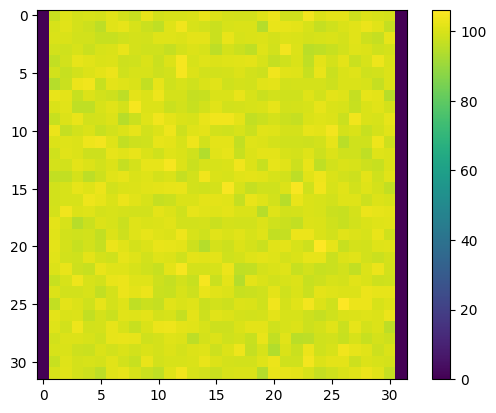

In [37]:
plt.imshow(true_obs.reshape(32, 32))
plt.colorbar()

In [48]:
true_obs

array([  0.      ,  97.40212 , 101.207344, ..., 100.86084 ,  97.593506,
         0.      ], dtype=float32)

In [49]:
noisy_obs = true_obs +  0.01*np.random.normal(loc=0, scale=0.1, size=true_obs.shape)

In [50]:
numerical_model_sw.set_obs(noisy_obs)
numerical_model_sw.cost_function(x0_t)


16it [00:02,  7.01it/s]                        


3542.7964801233484

In [65]:
numerical_model_sw.tests_consistency()
# res=  swmodel.forward_TLM_h(x0_t, n_steps=window)

Test Forw/TLM


16it [00:02,  7.04it/s]                        
16it [00:02,  6.96it/s]                        
16it [00:10,  1.57it/s]                        
16it [00:02,  7.06it/s]                        
16it [00:02,  6.93it/s]                        
16it [00:10,  1.52it/s]                        
16it [00:02,  7.01it/s]                        
16it [00:02,  6.90it/s]                        
16it [00:10,  1.54it/s]                        
16it [00:02,  6.96it/s]                        
16it [00:02,  6.73it/s]                        
16it [00:10,  1.55it/s]                        
16it [00:02,  6.98it/s]                        
16it [00:02,  7.01it/s]                        
16it [00:10,  1.57it/s]                        
16it [00:02,  6.99it/s]                        
16it [00:02,  7.03it/s]                        
16it [00:10,  1.58it/s]                        
16it [00:02,  7.01it/s]                        
16it [00:02,  7.05it/s]                        
16it [00:10,  1.55it/s]                 

TypeError: cannot unpack non-iterable NoneType object

In [59]:
import scipy.sparse.linalg as sla


In [61]:
res[0]
sla.aslinearoperator(np.asarray(res[0]))

<1024x3072 MatrixLinearOperator with dtype=float32>

In [34]:
# (H_obs @ np.where(np.isnan(no_obs), 0, no_obs) == remove_nan(no_obs[swmodel.slice_h])).all()


True

16it [00:02,  7.31it/s]                        
16it [00:02,  7.44it/s]                        
16it [00:02,  7.39it/s]                        
16it [00:02,  7.40it/s]                        
16it [00:02,  7.39it/s]                        
16it [00:02,  7.44it/s]                        
16it [00:02,  7.39it/s]                        
16it [00:02,  7.23it/s]                        
16it [00:02,  7.29it/s]                        
16it [00:02,  7.38it/s]                        
16it [00:02,  7.35it/s]                        
16it [00:02,  7.35it/s]                        
16it [00:02,  6.37it/s]                        
16it [00:02,  7.37it/s]                        
16it [00:02,  7.44it/s]                        
16it [00:02,  7.36it/s]                        
16it [00:02,  7.26it/s]                        
16it [00:02,  7.20it/s]                        
16it [00:02,  7.38it/s]                        
16it [00:02,  7.36it/s]                        
16it [00:02,  7.29it/s]                 

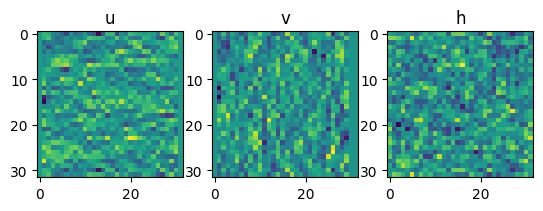

<Figure size 640x480 with 0 Axes>

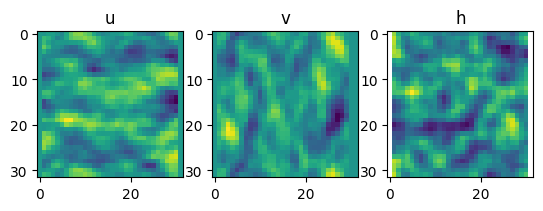

In [ ]:
swmodel.plot_state_imshow(x0_t)
swmodel.plot_state_imshow(new_state)
plt.figure()
for _ in range(50):
    new_state = numerical_model_sw.forward_no_obs(new_state)

plt.figure()
swmodel.plot_state_imshow(new_state)